# benchmarking on omnipath


In [12]:
from bengrn import BenGRN
import scanpy as sc


from anndata.utils import make_index_unique
from grnndata import utils as grnutils

import pandas as pd

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import shutil
import os

from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from grnndata import GRNAnnData

from geneformer import TOKEN_DICTIONARY_FILE
import pickle

with open(TOKEN_DICTIONARY_FILE, "rb") as f:
    gene_mapping_dict = pickle.load(f)

def compute_geneformer_network(adata, model="../../Geneformer/gf-12L-30M-i2048/", model_type="Pretrained", forward_batch_size=4, max_ncells=1000, ):
    adata = adata[:, adata.var.index.isin([u for u in gene_mapping_dict.keys() if u in adata.var.index])]
    adata.var['ensembl_id'] = adata.var.index
    adata.obs['n_counts'] = adata.X.sum(1)
    # Create the geneformer folder if it doesn't exist
    geneformer_folder = "/tmp/geneformer"
    if not os.path.exists(geneformer_folder):
        os.makedirs(geneformer_folder)
    adata.write_h5ad("/tmp/geneformer/test.h5ad")

    genelist = [gene_mapping_dict[u] for u in adata.var.index]

    tokenized_data_path = "/tmp/geneformer/tokenized_data.dataset/"
    if os.path.exists(tokenized_data_path):
        shutil.rmtree(tokenized_data_path)
    tk = TranscriptomeTokenizer(nproc=16, model_input_size=2048)
    tk.tokenize_data("/tmp/geneformer/", 
                    "/tmp/geneformer/",
                    "tokenized_data", 
                    file_format="h5ad")
    embex = EmbExtractor(model_type=model_type, #CellClassifier
                     max_ncells=max_ncells,
                     emb_mode="cell",
                     forward_batch_size=forward_batch_size,
                     nproc=16,
                     genelist=genelist)
    embs, avg_attentions = embex.extract_embs(model, #../../../Geneformer/fine_tuned_models/gf-6L-30M-i2048_CellClassifier_cardiomyopathies_220224/
                          "/tmp/geneformer/tokenized_data.dataset/",
                          "/tmp/geneformer",
                          "geneformertest",
                          get_avg_attentions=True,
                          )
    return GRNAnnData(adata.copy(), grn=avg_attentions.to("cpu").numpy())

In [14]:
genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']
NUM_GENES = 5000
MAXCELLS = 1024

In [15]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/gNNpgpo6gATjuxTE7CCp.h5ad')
#adata = sc.read_h5ad('../data/gNNpgpo6gATjuxTE7CCp.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata = adata[:, adata.var.index.isin(genes)]
adata

View of AnnData object with n_obs × n_vars = 51370 × 23149
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'uid', 'symbol', 'ncbi_gene_ids', 'biotype

In [16]:
CELLTYPES = [
"retinal rod cell",
"Mueller cell",
"amacrine cell",
"ON-bipolar cell",
"rod bipolar cell",
"retinal cone cell",
"retina horizontal cell",
"retinal ganglion cell",
"astrocyte",
"microglial cell",
]

/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/tmp/ipykernel_2823139/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


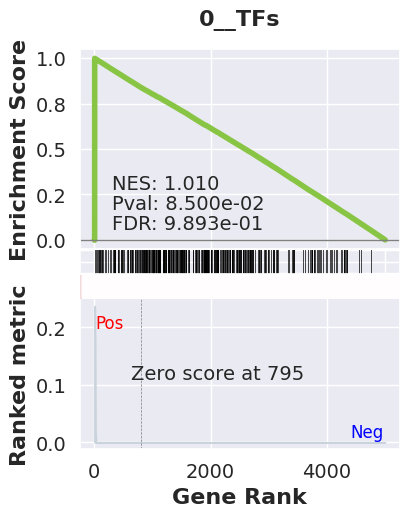

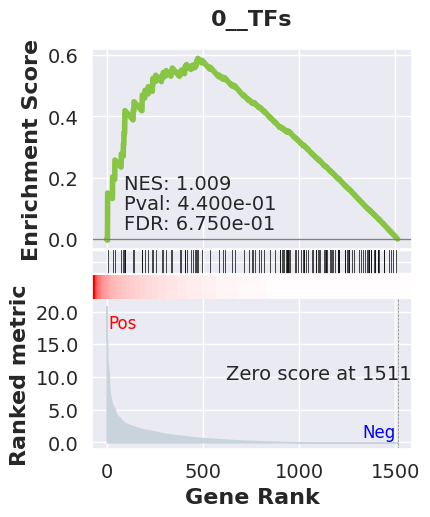

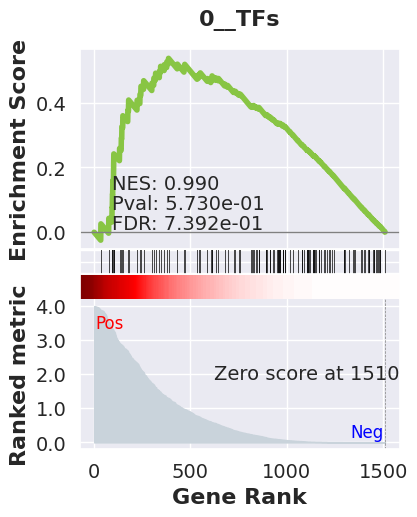

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2117 genes
intersection pct: 0.4234
precision:  0.0009433230227112625 
recall:  0.15979381443298968 
random precision: 0.0008516074089844582


 97%|█████████▋| 124/128 [00:00<00:00, 149.10it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 146.37it/s]


Average Precision (AP):  0.0010712843003418719
Area Under Precision-Recall Curve (AUPRC):  0.0008770783910623261
EPR: 1.2110018413970336


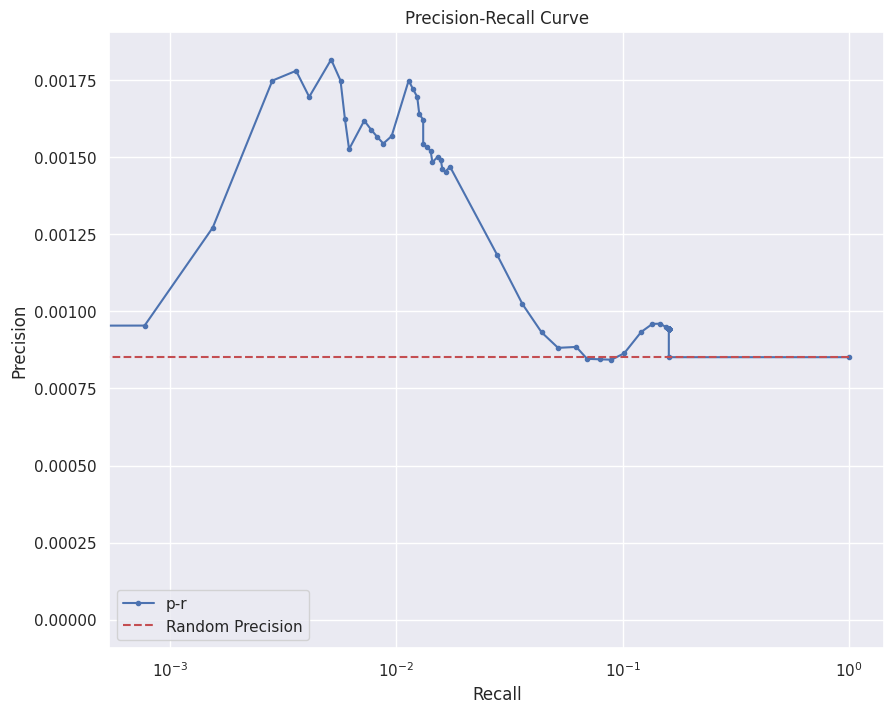

base enrichment
Top central genes: []


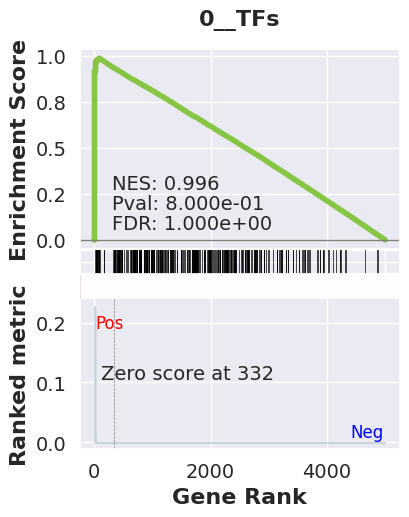

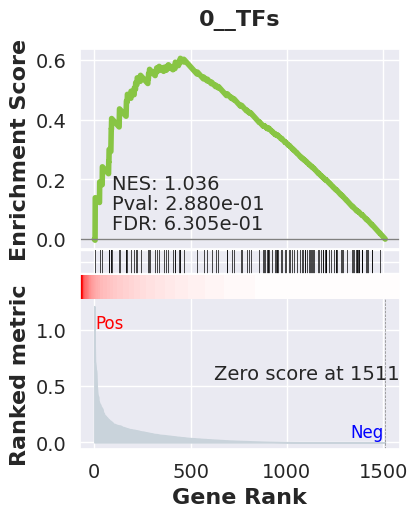

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2117 genes
intersection pct: 0.4234
precision:  0.005958427460315054 
recall:  0.10128865979381443 
random precision: 0.0008516074089844582


 95%|█████████▌| 122/128 [00:00<00:00, 150.38it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 145.68it/s]


Average Precision (AP):  0.002309456252629854
Area Under Precision-Recall Curve (AUPRC):  0.0014065760613853426
EPR: 10.7678913557032


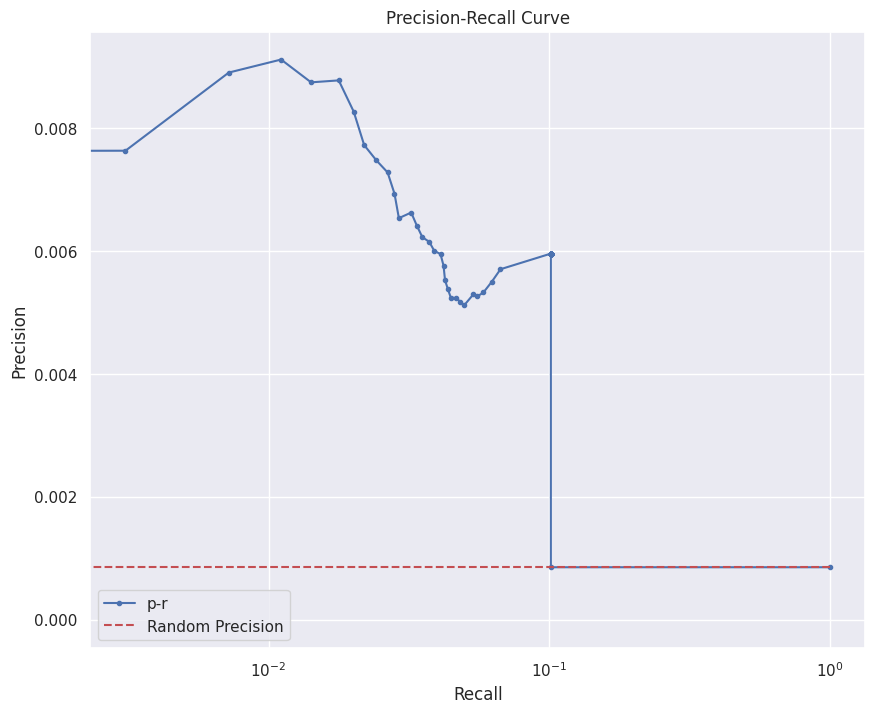

/tmp/ipykernel_2823139/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


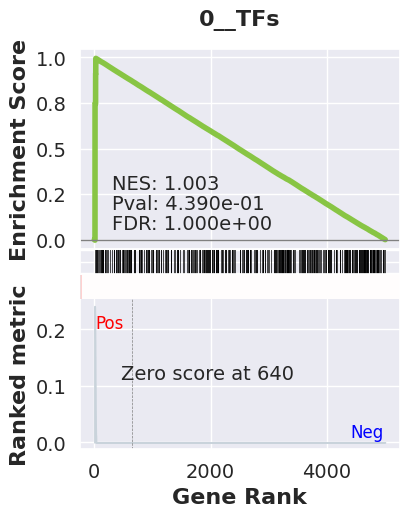

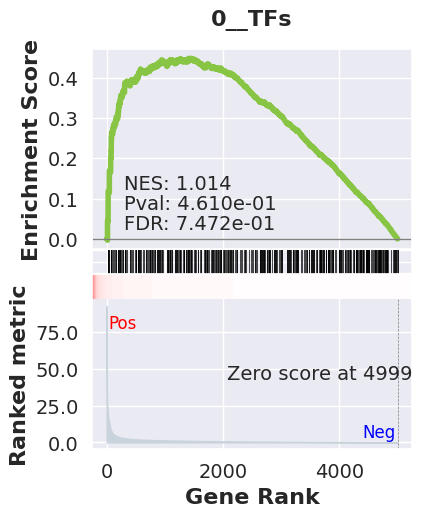

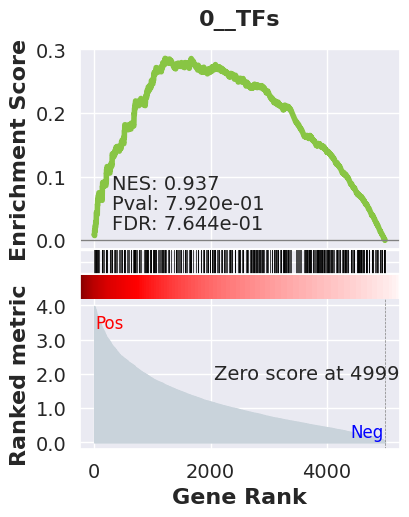

_________________________________________
TF specific enrichment
found some significant results for  20.689655172413794 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3636 genes
intersection pct: 0.7272
precision:  0.0013721925796491416 
recall:  0.993620765508139 
random precision: 0.0013758184621763415


 98%|█████████▊| 125/128 [00:02<00:00, 45.39it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 46.84it/s]


Average Precision (AP):  0.0016728082672405882
Area Under Precision-Recall Curve (AUPRC):  0.0016724027405363574
EPR: 1.9637861673572339


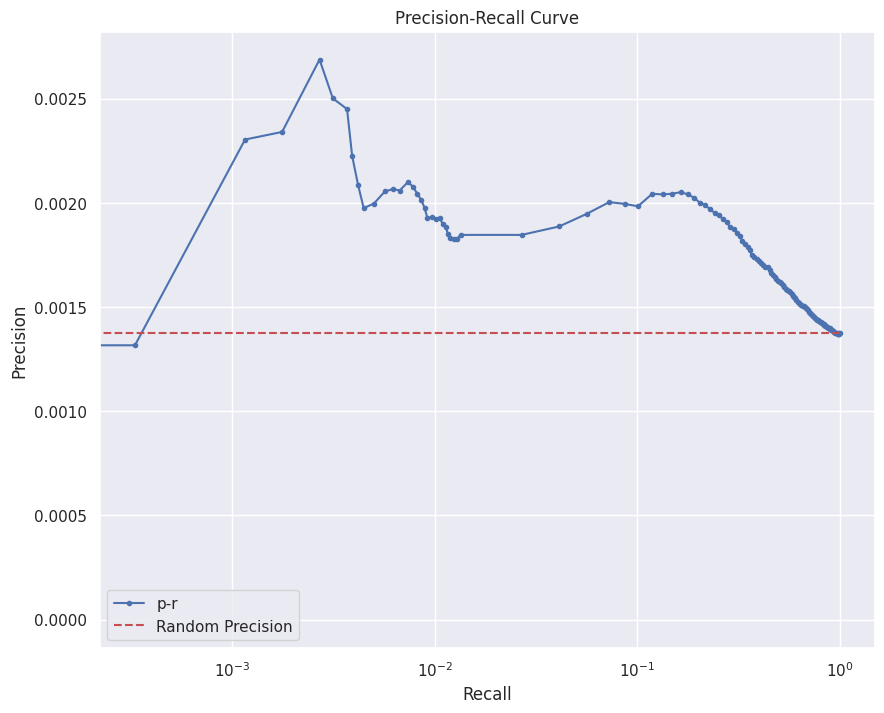

base enrichment
Top central genes: []


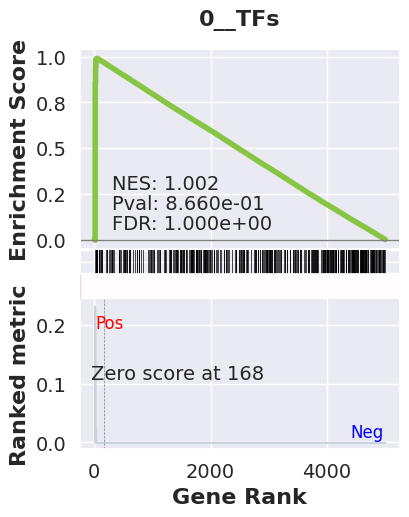

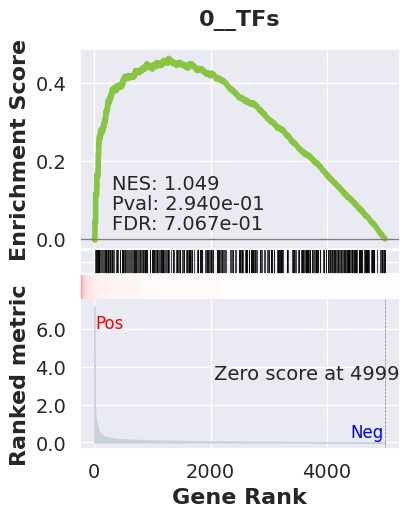

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3636 genes
intersection pct: 0.7272
precision:  0.006042083871179213 
recall:  0.42575890893092827 
random precision: 0.0013758184621763415


 97%|█████████▋| 124/128 [00:02<00:00, 46.53it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 44.32it/s]


Average Precision (AP):  0.004267204756136314
Area Under Precision-Recall Curve (AUPRC):  0.0036756689853387854
EPR: 6.57424679814943


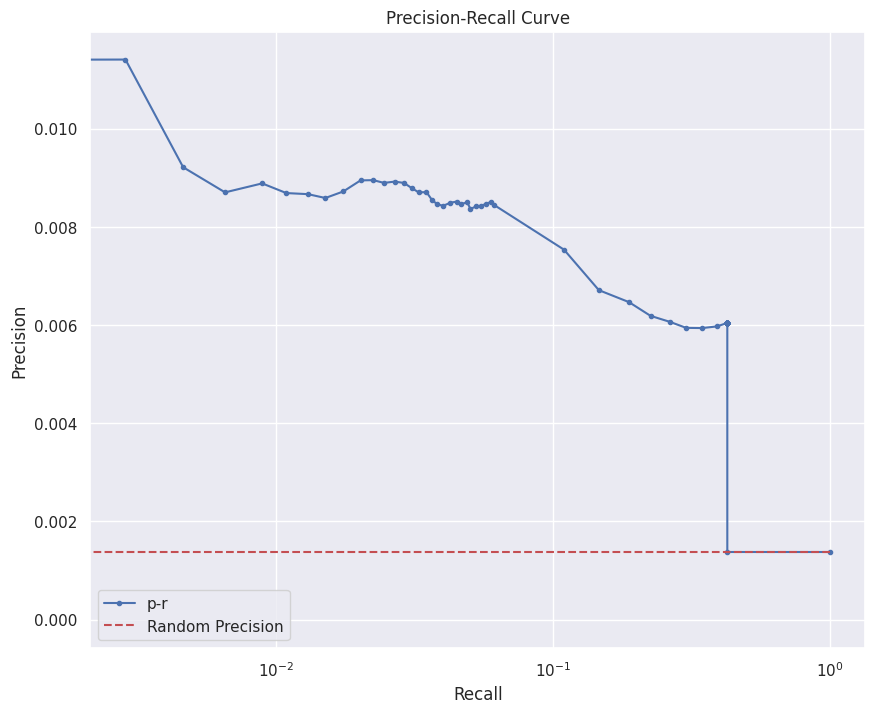

/tmp/ipykernel_2823139/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


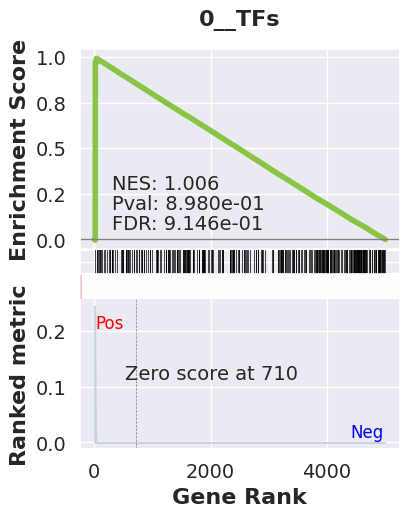

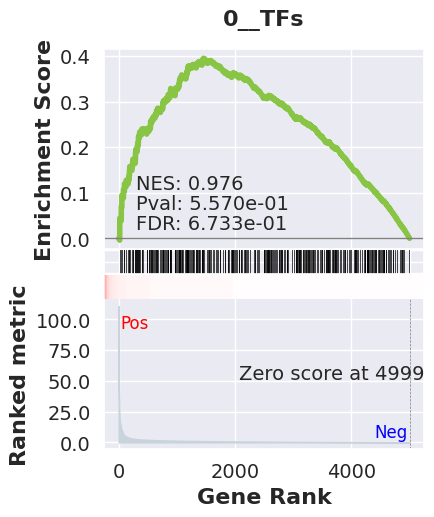

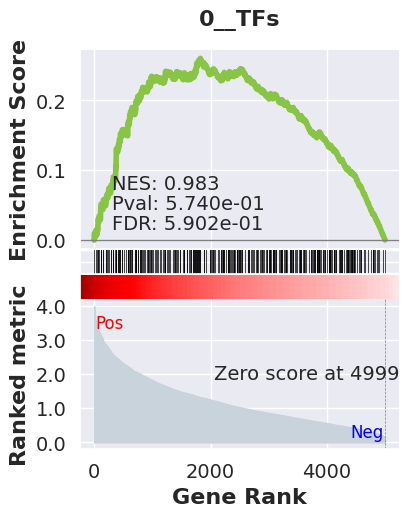

_________________________________________
TF specific enrichment
found some significant results for  21.428571428571427 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3600 genes
intersection pct: 0.72
precision:  0.0008186247628743175 
recall:  1.0 
random precision: 0.0008187459479485043


 98%|█████████▊| 125/128 [00:02<00:00, 49.21it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 48.95it/s]


Average Precision (AP):  0.0009420424115334197
Area Under Precision-Recall Curve (AUPRC):  0.0009410523396867942
EPR: 1.3825166188057032


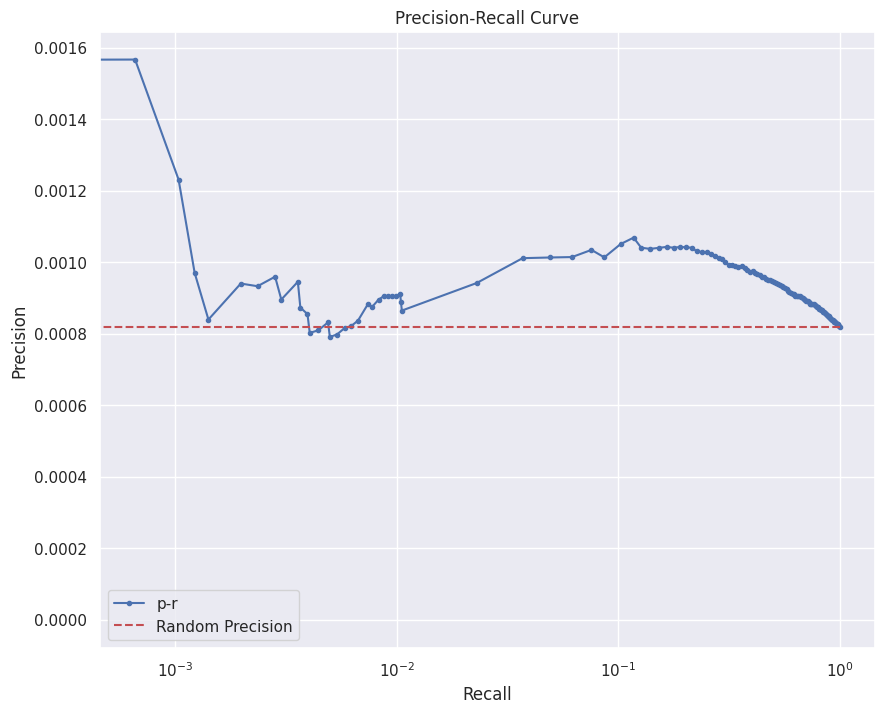

base enrichment
Top central genes: []


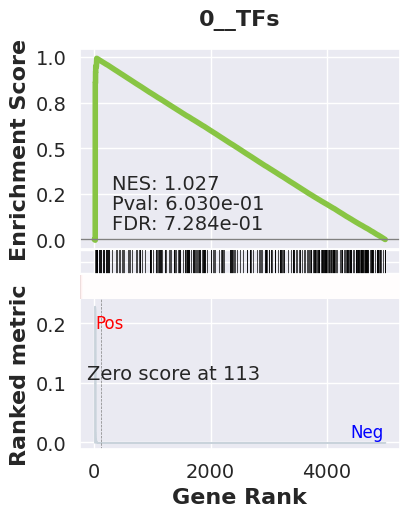

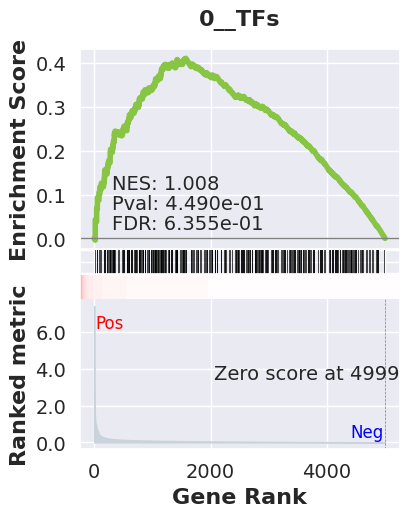

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3600 genes
intersection pct: 0.72
precision:  0.0029004011696182976 
recall:  0.277526395173454 
random precision: 0.0008187459479485043


 98%|█████████▊| 125/128 [00:02<00:00, 45.98it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 45.85it/s]


Average Precision (AP):  0.0018435264478972853
Area Under Precision-Recall Curve (AUPRC):  0.0014540763157915738
EPR: 4.399542411763179


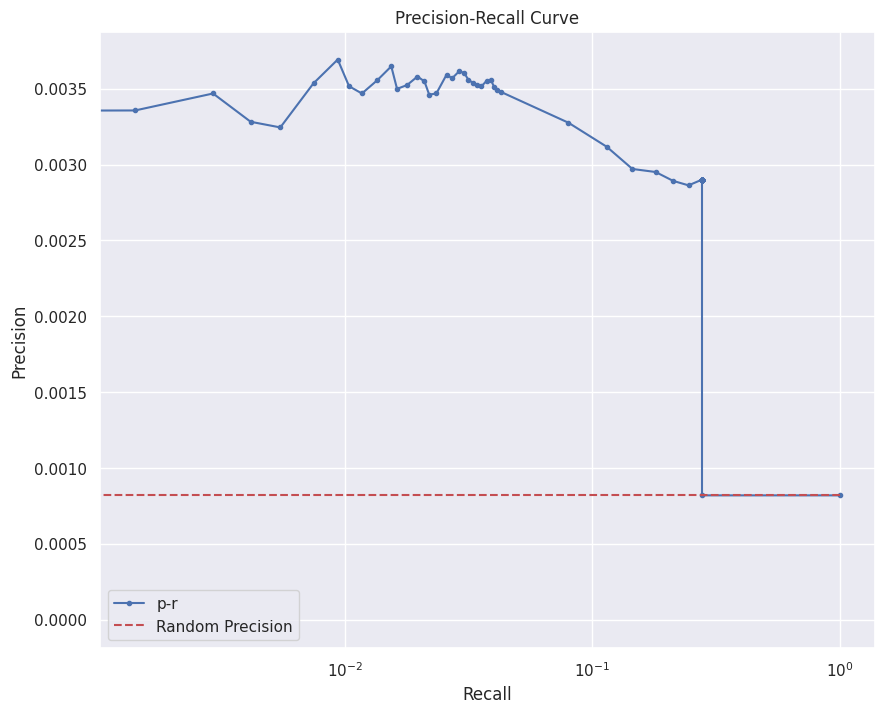

/tmp/ipykernel_2823139/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


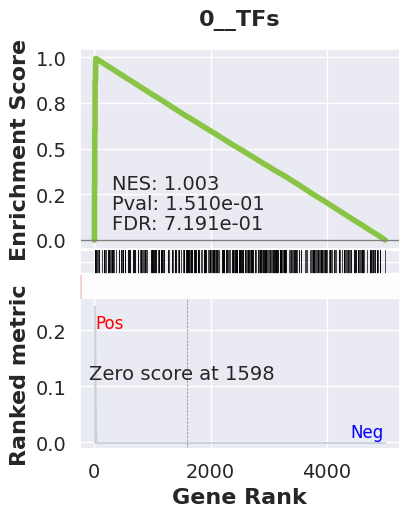

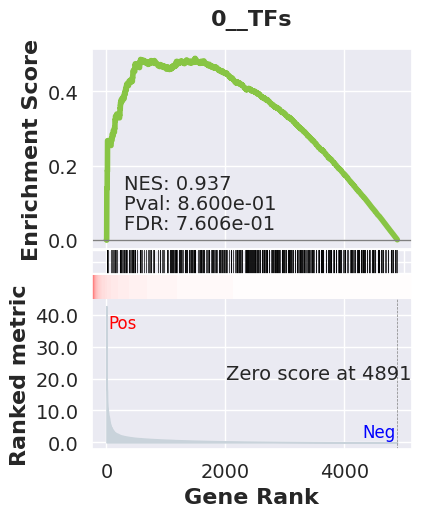

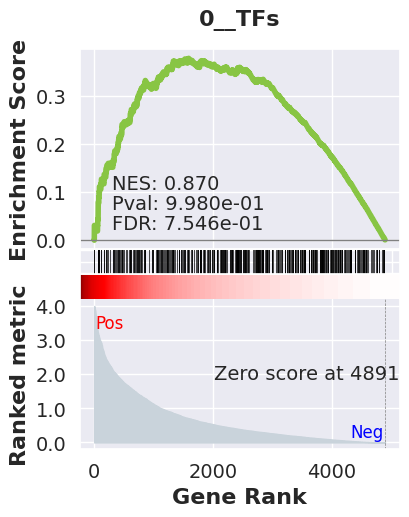

_________________________________________
TF specific enrichment
found some significant results for  3.3333333333333335 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3357 genes
intersection pct: 0.6714
precision:  0.0007601662381513699 
recall:  0.8355088367794848 
random precision: 0.0007684119746226109


 99%|█████████▉| 127/128 [00:02<00:00, 55.04it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 56.48it/s]


Average Precision (AP):  0.000965539072041636
Area Under Precision-Recall Curve (AUPRC):  0.0009608562946918724
EPR: 2.713011270277927


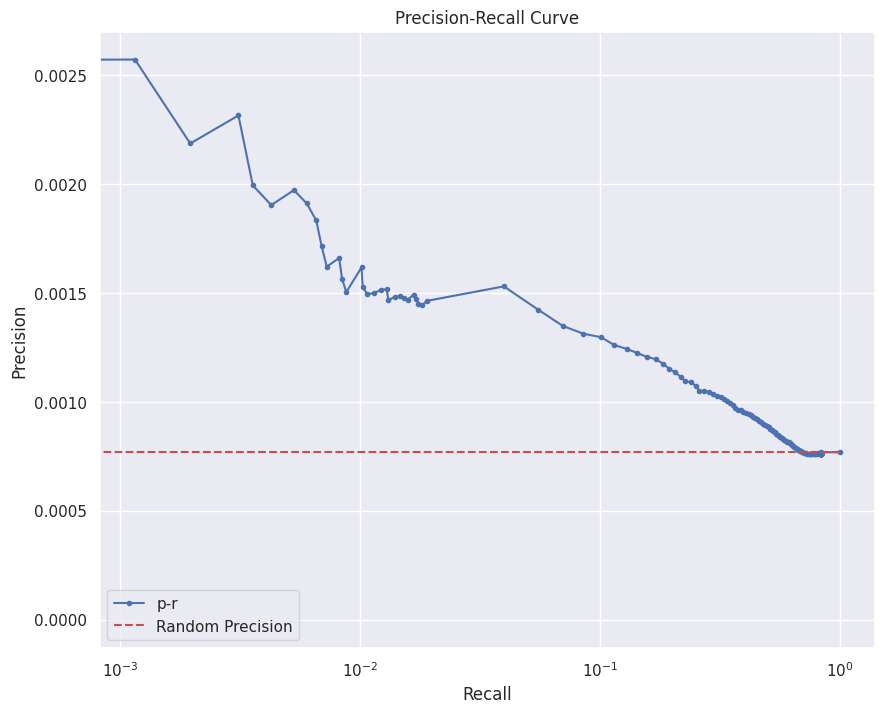

base enrichment
Top central genes: []


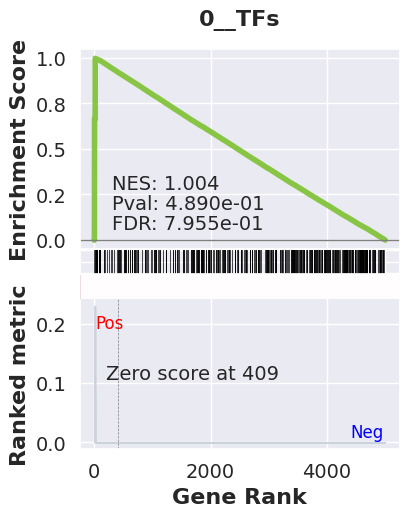

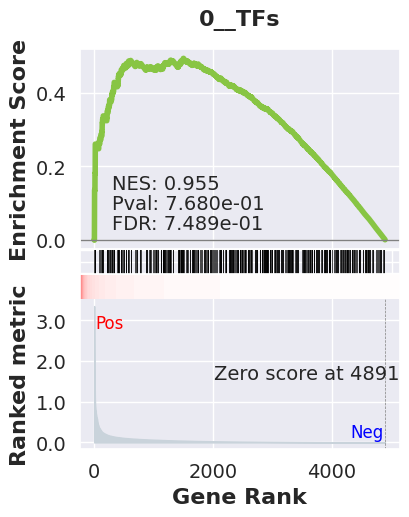

_________________________________________
TF specific enrichment
found some significant results for  6.666666666666667 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3357 genes
intersection pct: 0.6714
precision:  0.0022571608744530783 
recall:  0.2683377613491972 
random precision: 0.0007684119746226109


 98%|█████████▊| 126/128 [00:02<00:00, 56.10it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 56.64it/s]


Average Precision (AP):  0.0013511565830115746
Area Under Precision-Recall Curve (AUPRC):  0.0011369963112314906
EPR: 3.6223802085127246


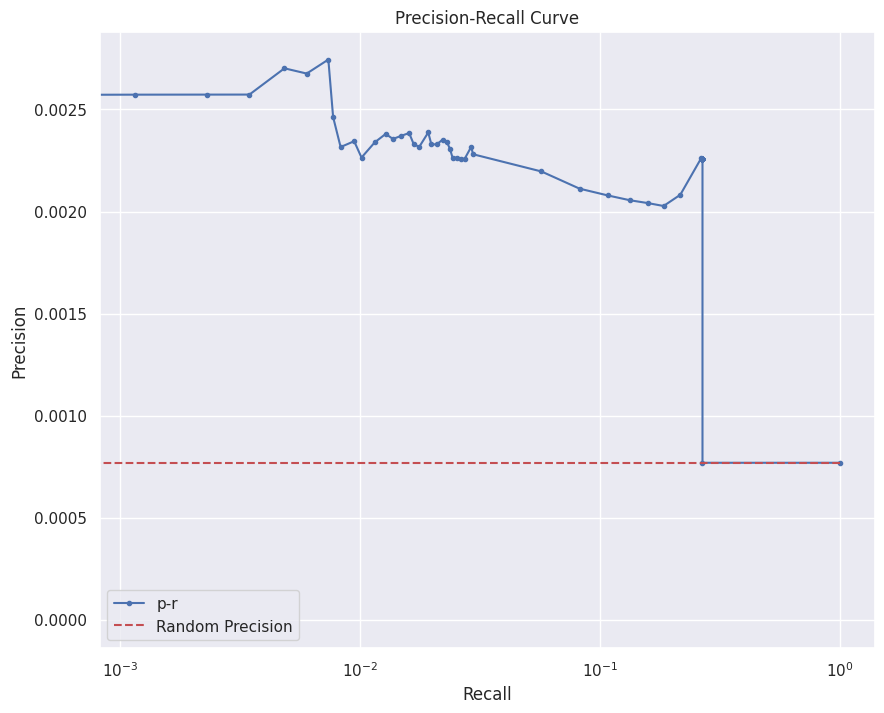

/tmp/ipykernel_2823139/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


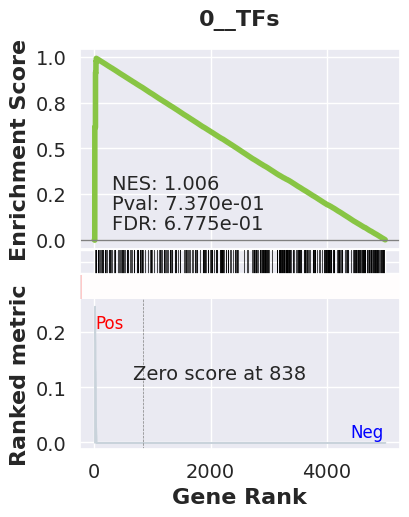

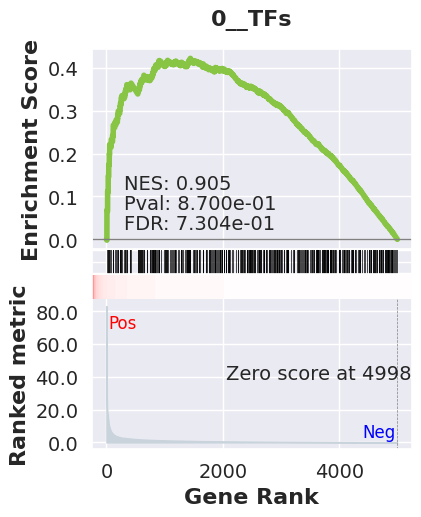

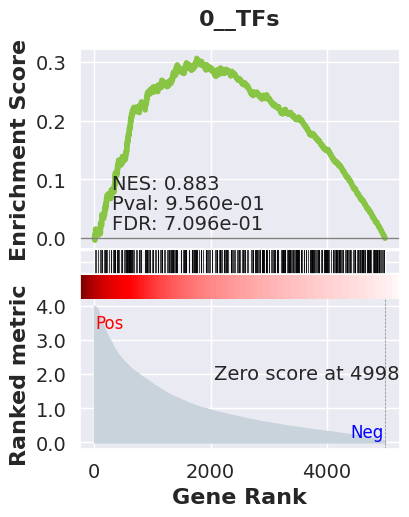

_________________________________________
TF specific enrichment
found some significant results for  7.142857142857143 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3522 genes
intersection pct: 0.7044
precision:  0.0006745555736545549 
recall:  0.9962802975761939 
random precision: 0.0006720446365370686


 97%|█████████▋| 124/128 [00:02<00:00, 51.33it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 51.17it/s]


Average Precision (AP):  0.0008778727205691224
Area Under Precision-Recall Curve (AUPRC):  0.000877418812878566
EPR: 1.7873411781983906


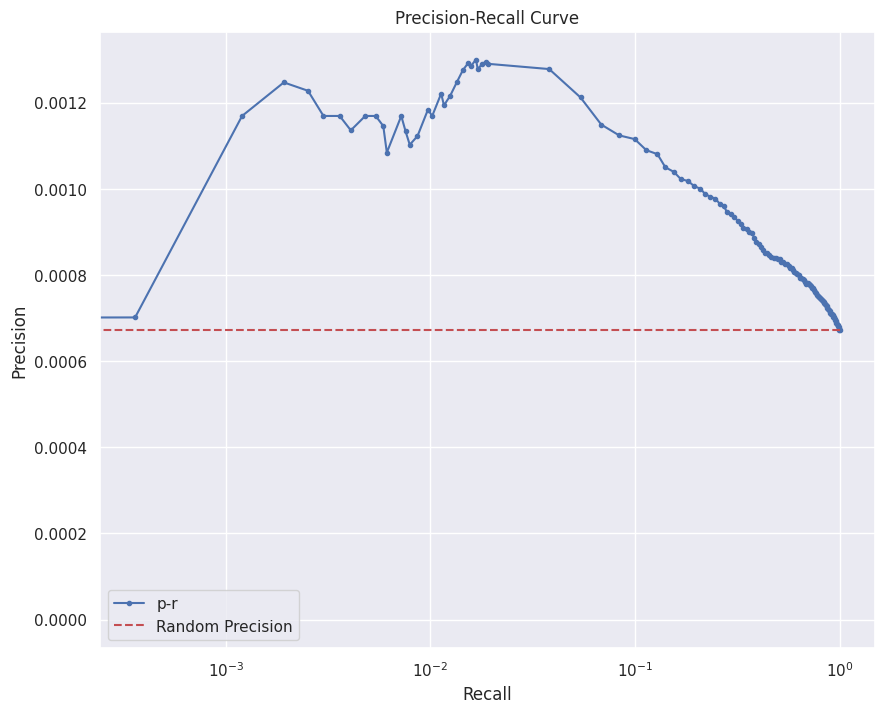

base enrichment
Top central genes: []


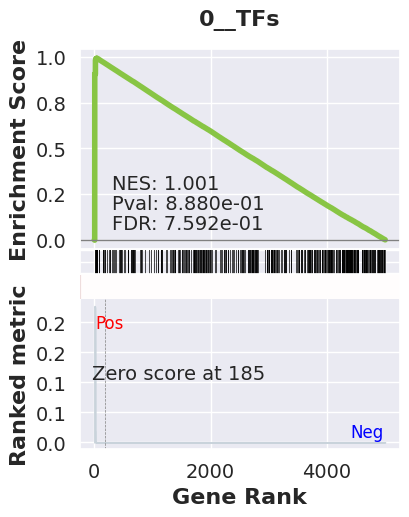

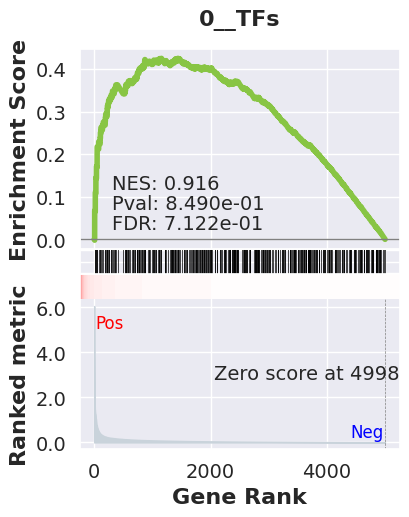

_________________________________________
TF specific enrichment
found some significant results for  17.857142857142858 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3522 genes
intersection pct: 0.7044
precision:  0.0016882851250234366 
recall:  0.2377009839212863 
random precision: 0.0006720446365370686


 98%|█████████▊| 125/128 [00:02<00:00, 50.23it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 50.71it/s]


Average Precision (AP):  0.0012131232966110493
Area Under Precision-Recall Curve (AUPRC):  0.0010026318868569242
EPR: 4.845599809373786


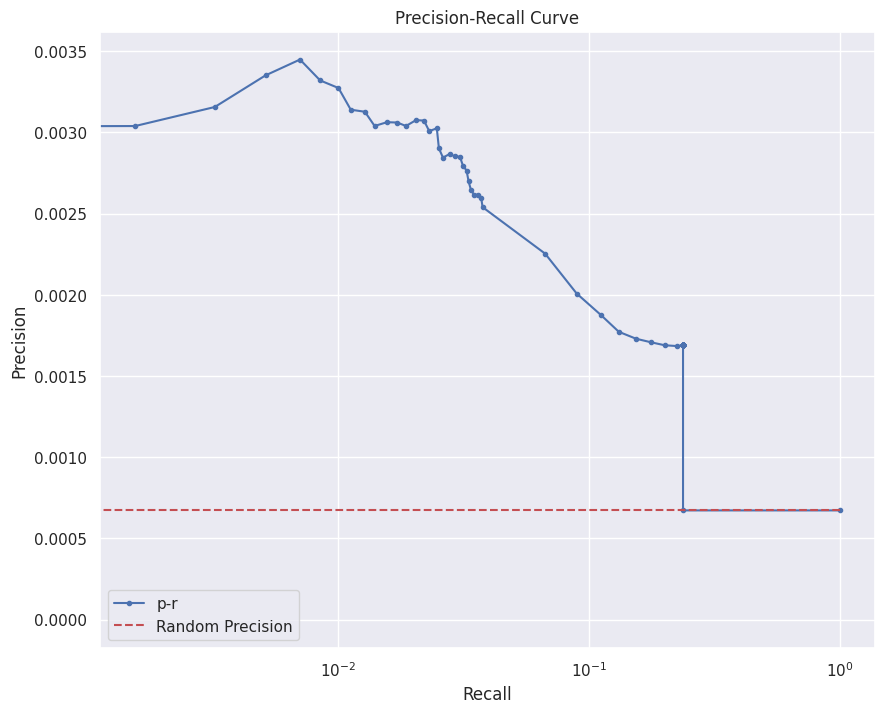

/tmp/ipykernel_2823139/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


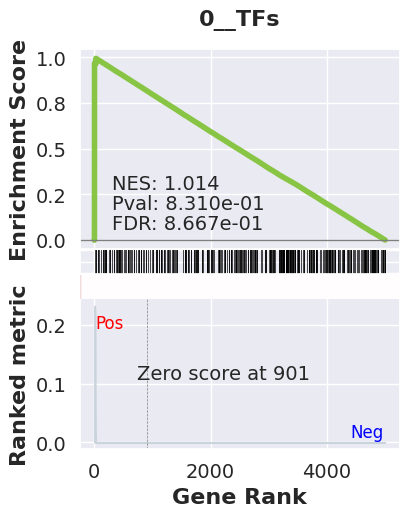

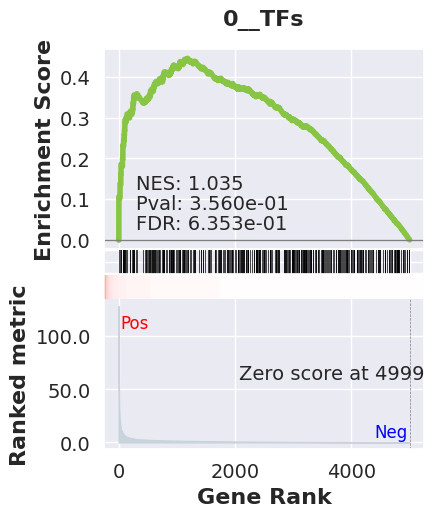

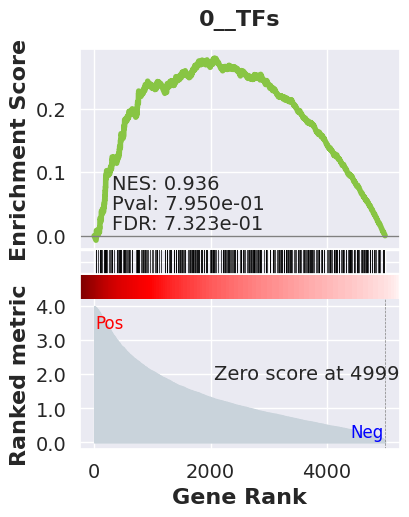

_________________________________________
TF specific enrichment
found some significant results for  15.151515151515152 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3522 genes
intersection pct: 0.7044
precision:  0.0007677649430538696 
recall:  0.9994747899159664 
random precision: 0.000767682378189692


 96%|█████████▌| 123/128 [00:02<00:00, 49.48it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 50.39it/s]


Average Precision (AP):  0.0009589422692304617
Area Under Precision-Recall Curve (AUPRC):  0.0009581598907239489
EPR: 1.9183196288399513


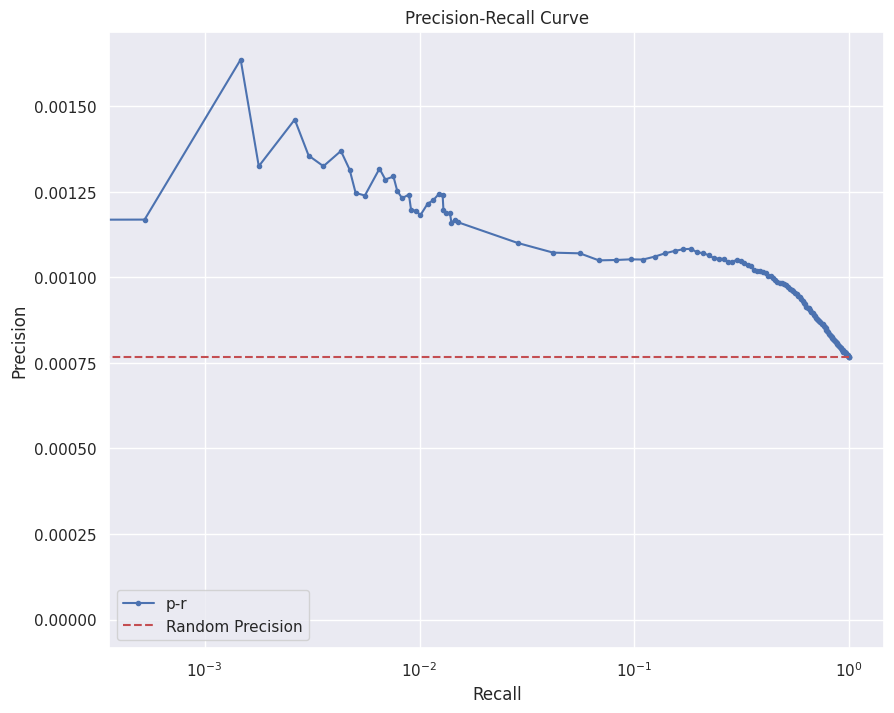

base enrichment
Top central genes: []


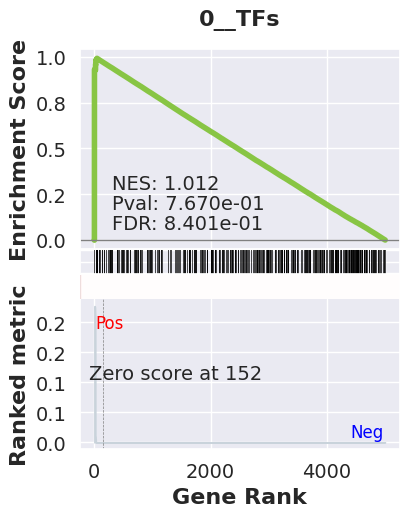

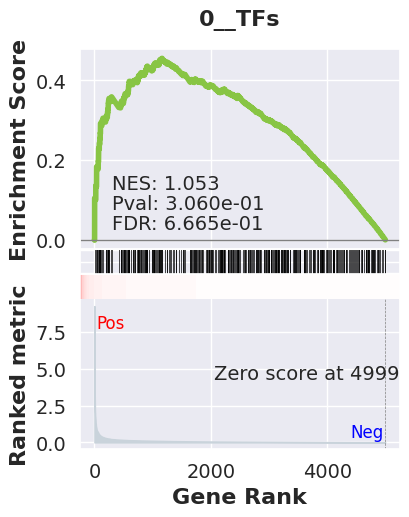

_________________________________________
TF specific enrichment
found some significant results for  18.181818181818183 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3522 genes
intersection pct: 0.7044
precision:  0.0028294451748818775 
recall:  0.31376050420168067 
random precision: 0.000767682378189692


 98%|█████████▊| 125/128 [00:02<00:00, 51.33it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 51.83it/s]


Average Precision (AP):  0.0019090116676192344
Area Under Precision-Recall Curve (AUPRC):  0.001582955995043804
EPR: 8.021437506079005


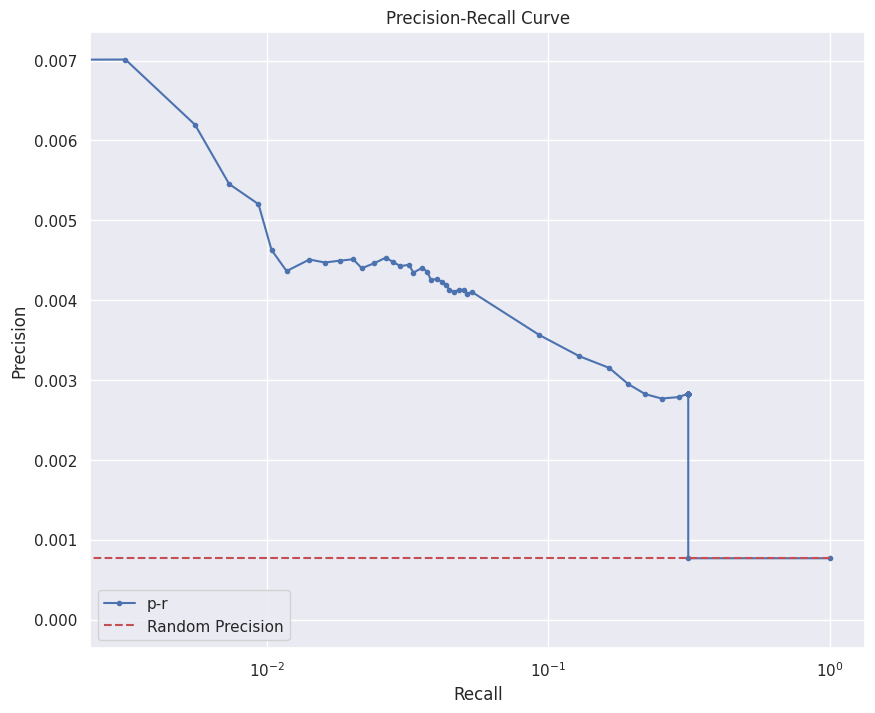

/tmp/ipykernel_2823139/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/250 [00:00<?, ?it/s]

base enrichment
Top central genes: []


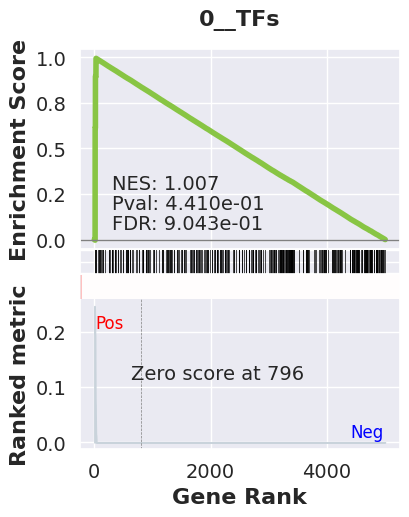

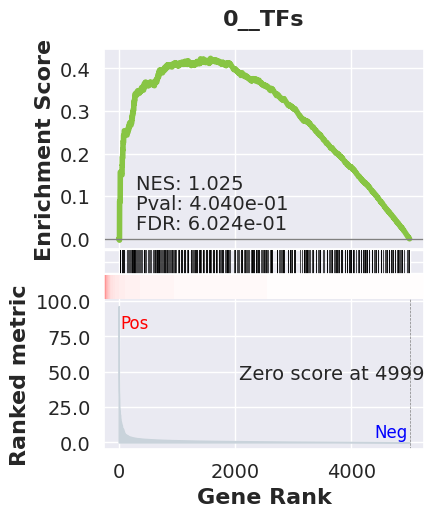

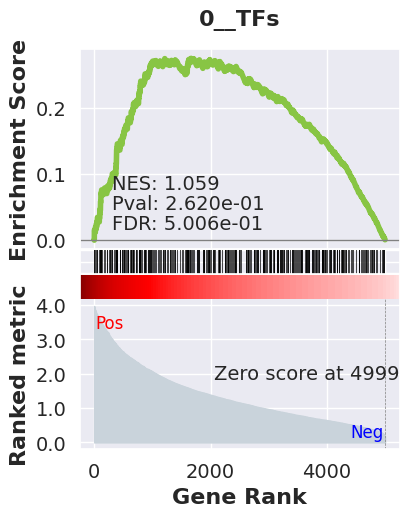

_________________________________________
TF specific enrichment
found some significant results for  26.923076923076923 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3551 genes
intersection pct: 0.7102
precision:  0.0010249412685020178 
recall:  1.0 
random precision: 0.0010252220164127543


 98%|█████████▊| 125/128 [00:02<00:00, 47.05it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 46.74it/s]


Average Precision (AP):  0.0012080151456658644
Area Under Precision-Recall Curve (AUPRC):  0.0012073160160383073
EPR: 0.9054870429743462


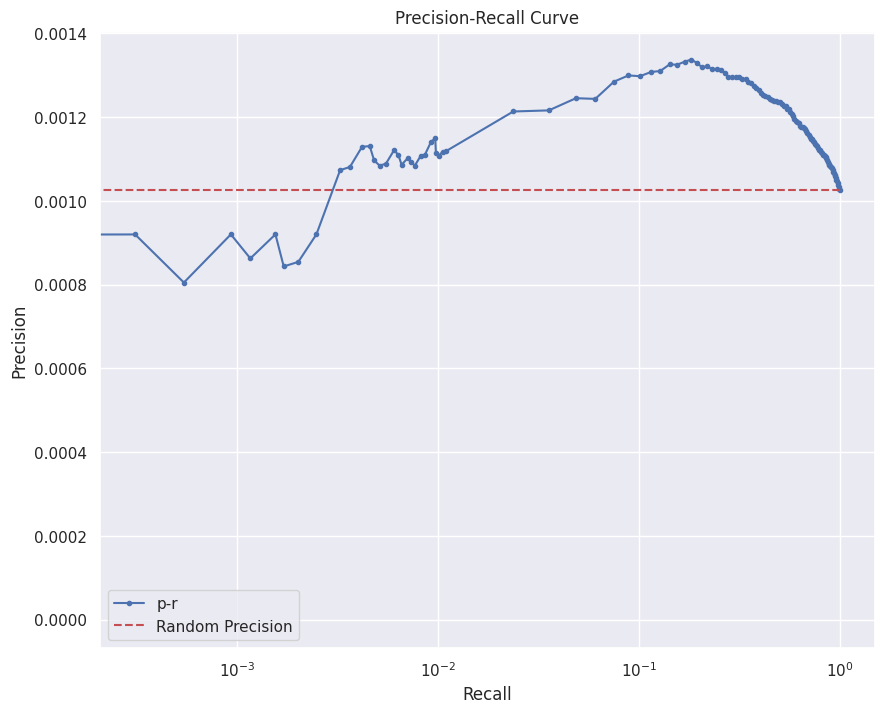

base enrichment
Top central genes: []


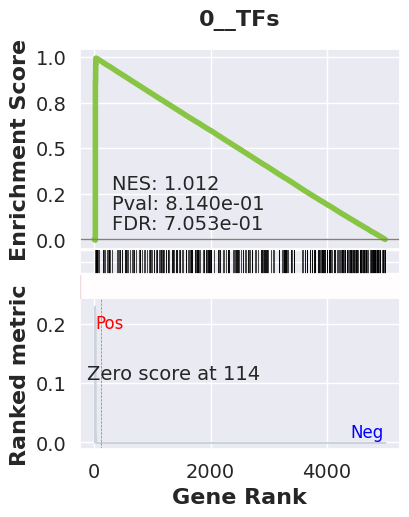

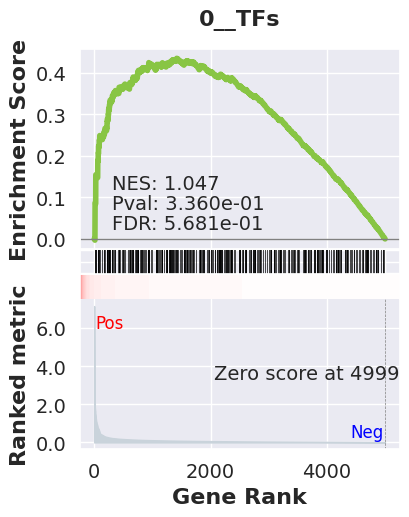

_________________________________________
TF specific enrichment
found some significant results for  11.538461538461538 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3551 genes
intersection pct: 0.7102
precision:  0.003778232872841966 
recall:  0.3166202414113278 
random precision: 0.0010252220164127543


 98%|█████████▊| 126/128 [00:02<00:00, 46.99it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 47.58it/s]


Average Precision (AP):  0.0024663164437362687
Area Under Precision-Recall Curve (AUPRC):  0.002040048185160089
EPR: 4.791603378950548


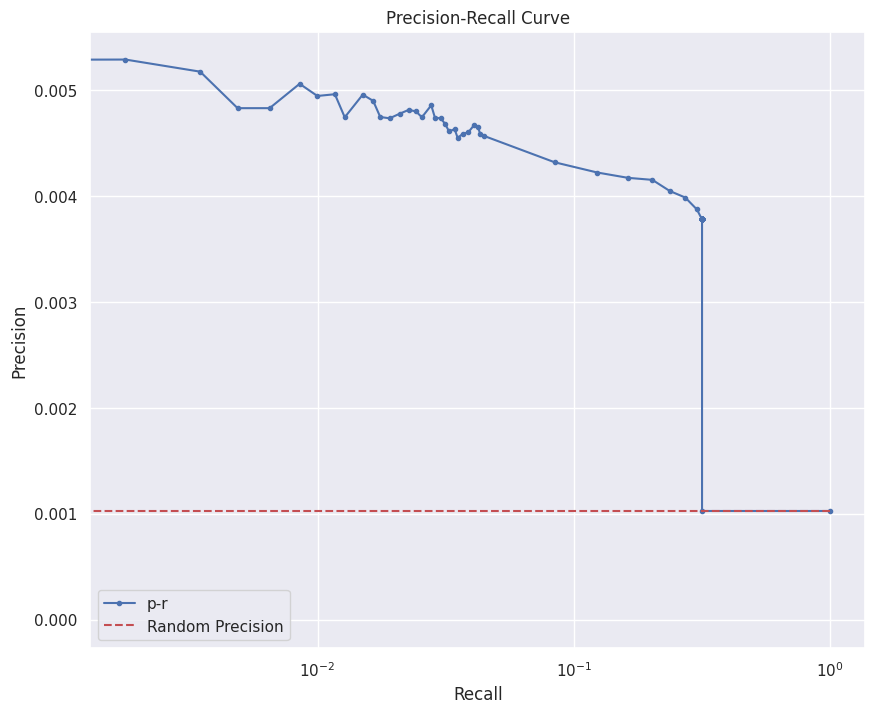

/tmp/ipykernel_2823139/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/123 [00:00<?, ?it/s]

base enrichment
Top central genes: []


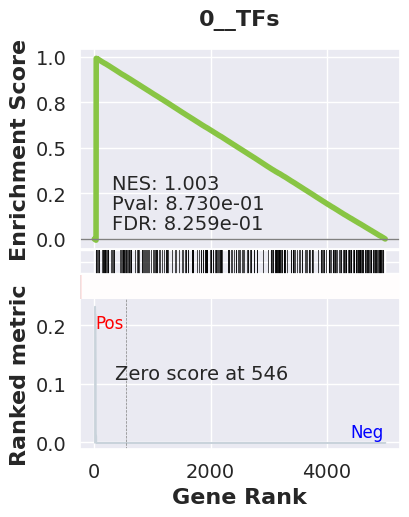

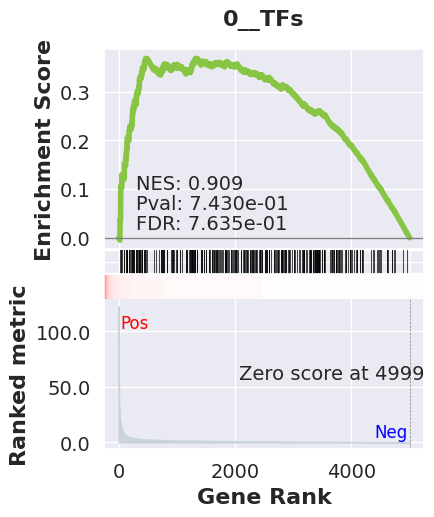

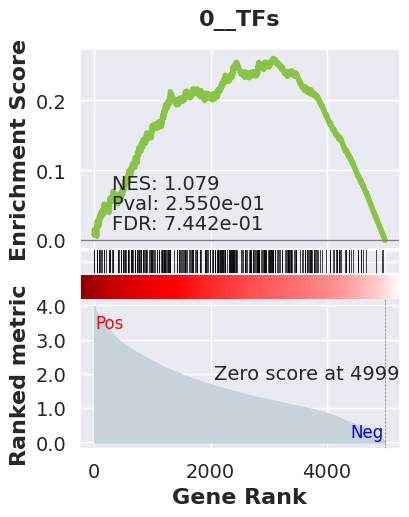

_________________________________________
TF specific enrichment
found some significant results for  16.666666666666668 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3675 genes
intersection pct: 0.735
precision:  0.0009556848146112396 
recall:  0.9961912164788185 
random precision: 0.0009528253326371376


 96%|█████████▌| 123/128 [00:02<00:00, 46.51it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 47.42it/s]


Average Precision (AP):  0.001015733542423588
Area Under Precision-Recall Curve (AUPRC):  0.001014847338699994
EPR: 1.0606459298800615


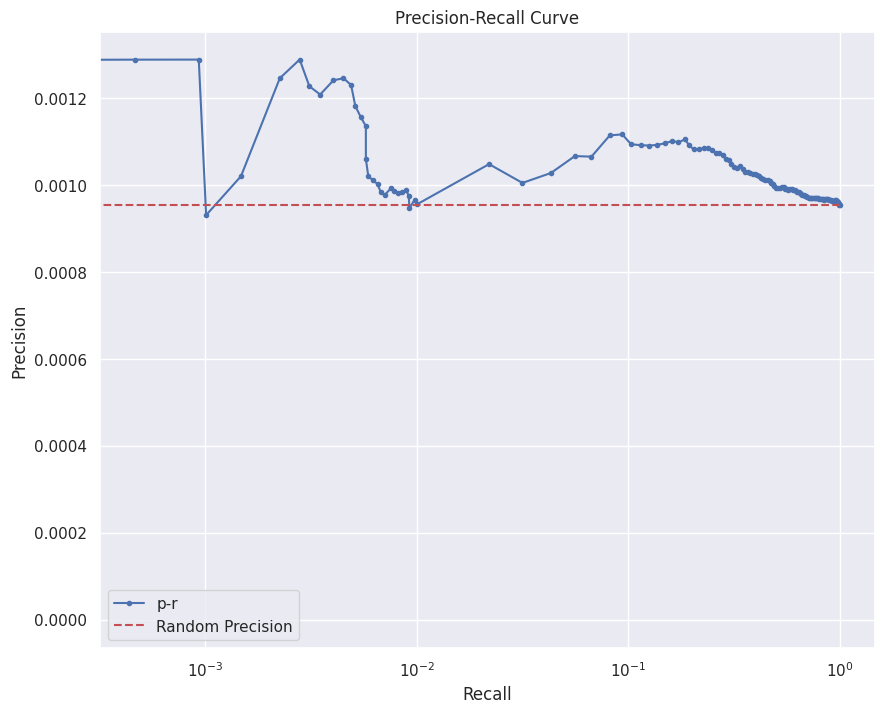

base enrichment
Top central genes: []


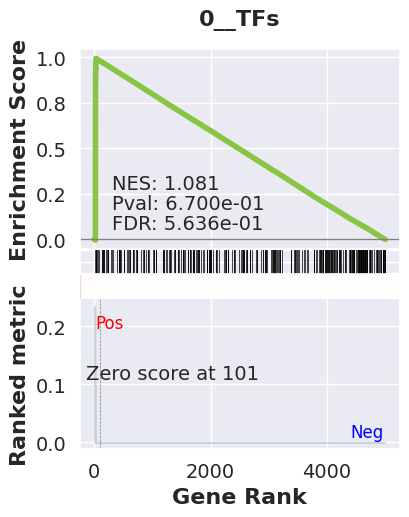

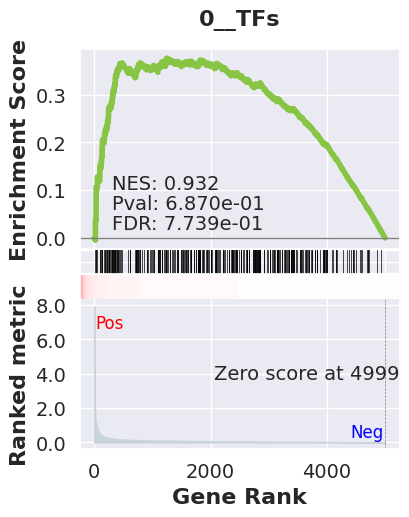

_________________________________________
TF specific enrichment
found some significant results for  4.166666666666667 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3675 genes
intersection pct: 0.735
precision:  0.003120771865983059 
recall:  0.22984842596191216 
random precision: 0.0009528253326371376


 97%|█████████▋| 124/128 [00:02<00:00, 47.73it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 46.43it/s]


Average Precision (AP):  0.0018745789043697894
Area Under Precision-Recall Curve (AUPRC):  0.0015243032606979232
EPR: 4.682547019576303


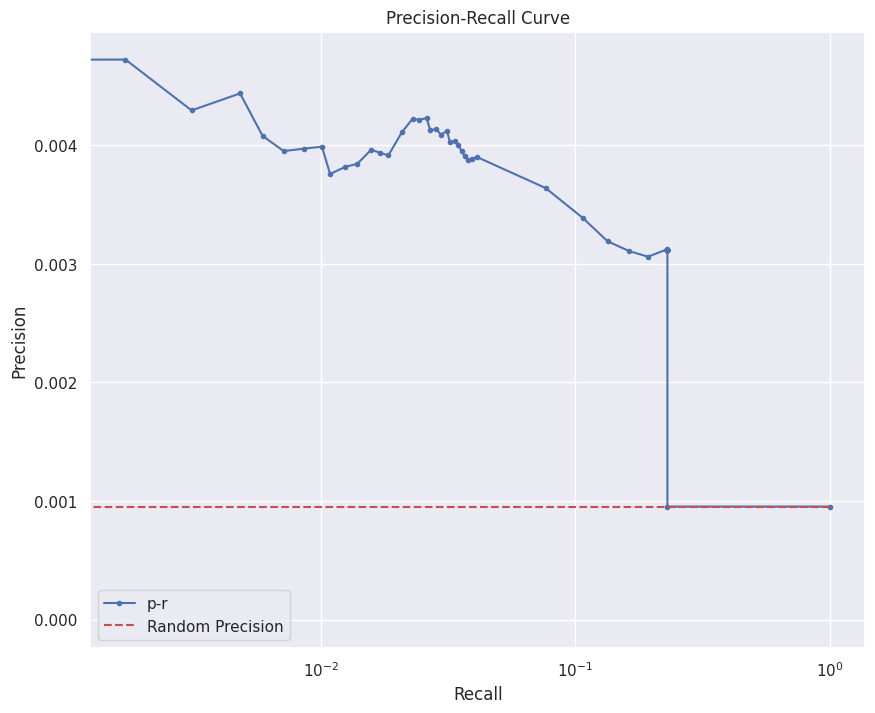

/tmp/ipykernel_2823139/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/58 [00:00<?, ?it/s]

base enrichment
Top central genes: []


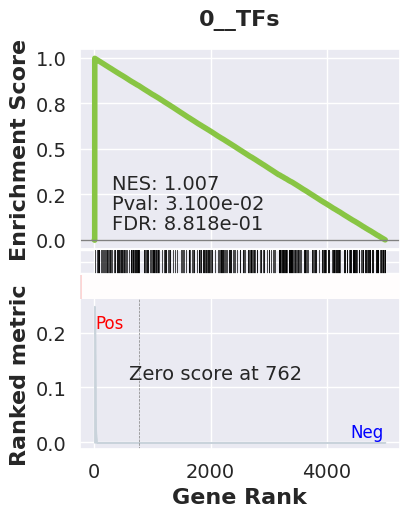

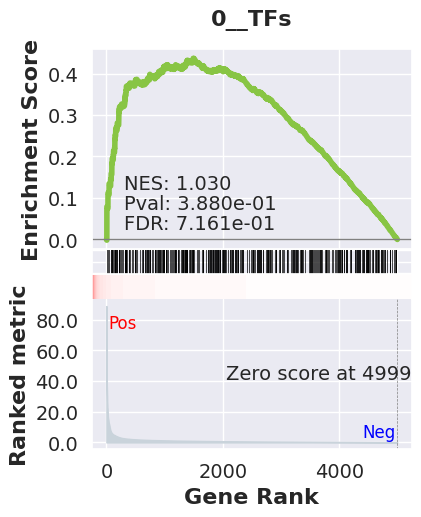

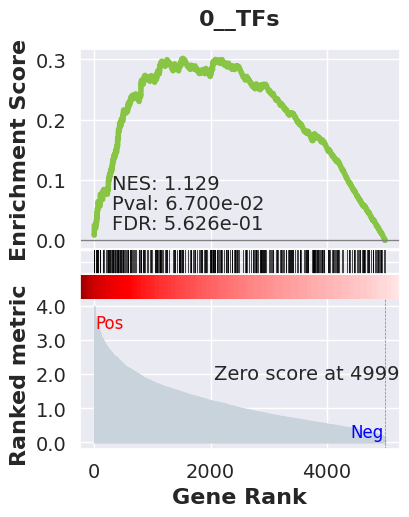

_________________________________________
TF specific enrichment
found some significant results for  28.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3646 genes
intersection pct: 0.7292
precision:  0.0014347636620787227 
recall:  0.9966354747134897 
random precision: 0.0014313372717305998


 98%|█████████▊| 125/128 [00:02<00:00, 41.95it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 42.76it/s]


Average Precision (AP):  0.0018174250194960147
Area Under Precision-Recall Curve (AUPRC):  0.0018165884133762031
EPR: 1.5819486548121422


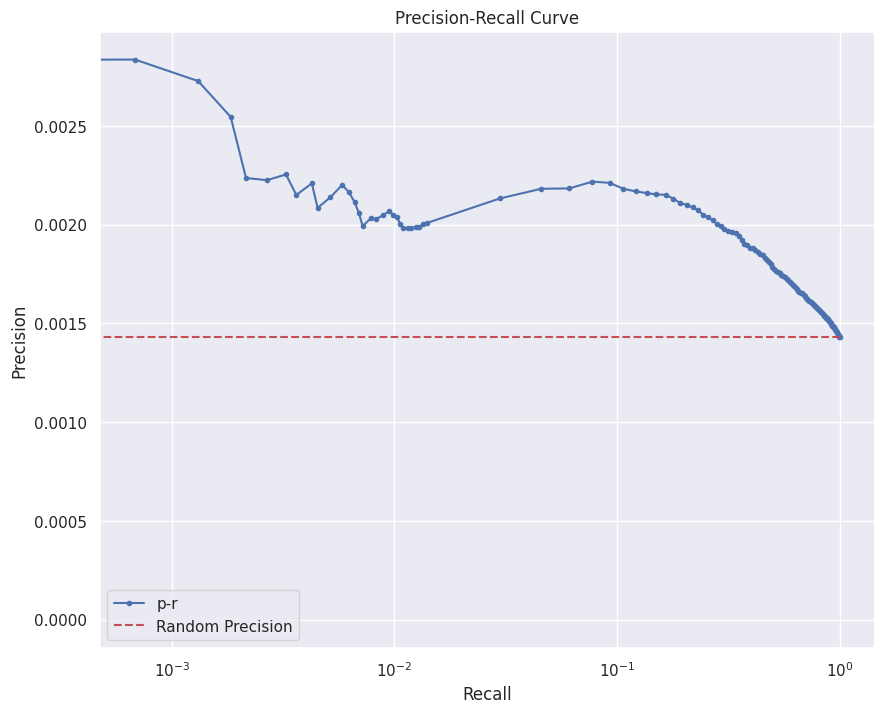

base enrichment
Top central genes: []


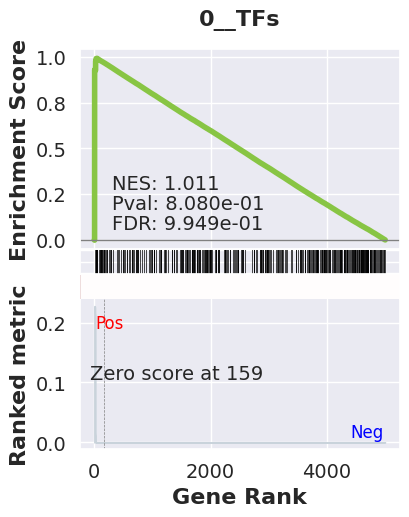

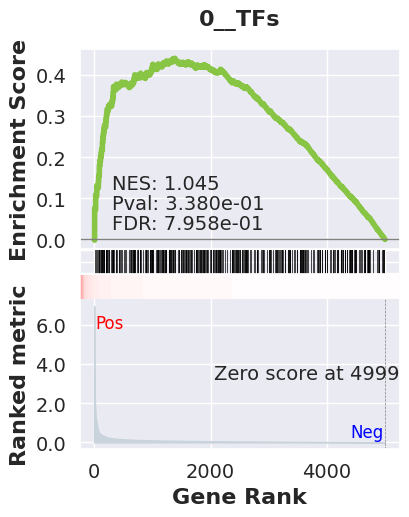

_________________________________________
TF specific enrichment
found some significant results for  6.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3646 genes
intersection pct: 0.7292
precision:  0.006668683336665966 
recall:  0.4102618021238566 
random precision: 0.0014313372717305998


 98%|█████████▊| 125/128 [00:02<00:00, 44.83it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 44.70it/s]


Average Precision (AP):  0.004650453208932331
Area Under Precision-Recall Curve (AUPRC):  0.004046885208764225
EPR: 6.566731096346647


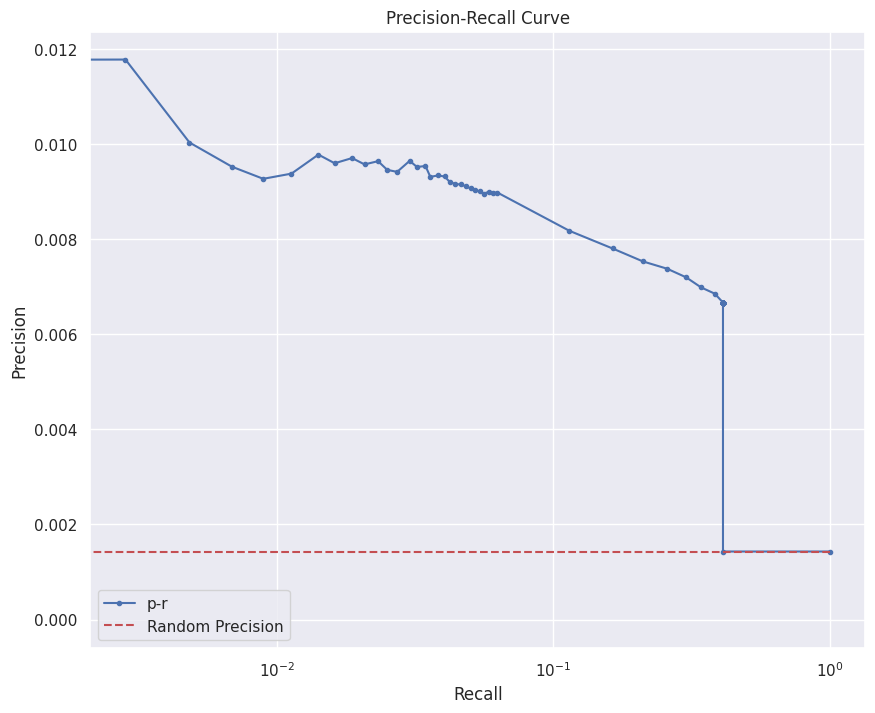

/tmp/ipykernel_2823139/468805686.py:16: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
[d3graph] WARNING> CLS token present in token dictionary, excluding from average.
[d3graph] WARNING> EOS token present in token dictionary, excluding from average.


  0%|          | 0/58 [00:00<?, ?it/s]

base enrichment
Top central genes: []


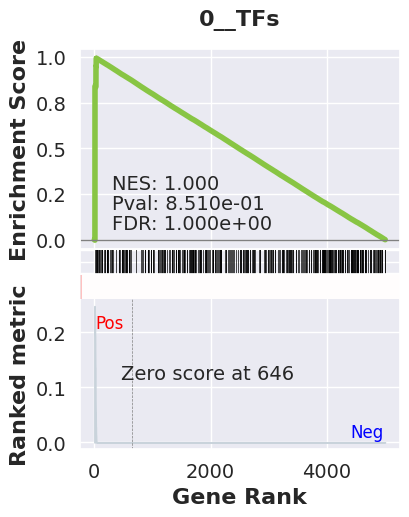

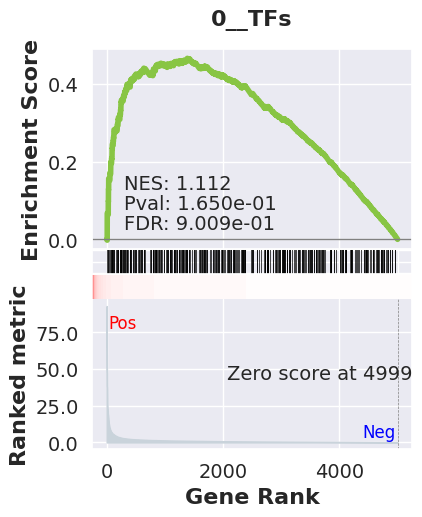

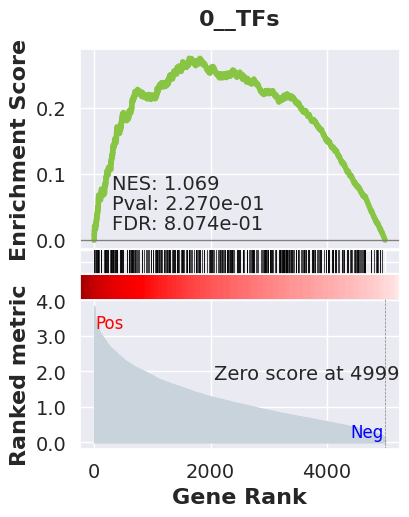

_________________________________________
TF specific enrichment
found some significant results for  28.78787878787879 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3763 genes
intersection pct: 0.7526
precision:  0.0018308921556396945 
recall:  0.9928304359557492 
random precision: 0.0018325979065590518


 98%|█████████▊| 125/128 [00:02<00:00, 42.94it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:03<00:00, 42.32it/s]


Average Precision (AP):  0.002119016489776237
Area Under Precision-Recall Curve (AUPRC):  0.0021185764633752067
EPR: 1.2843824377171145


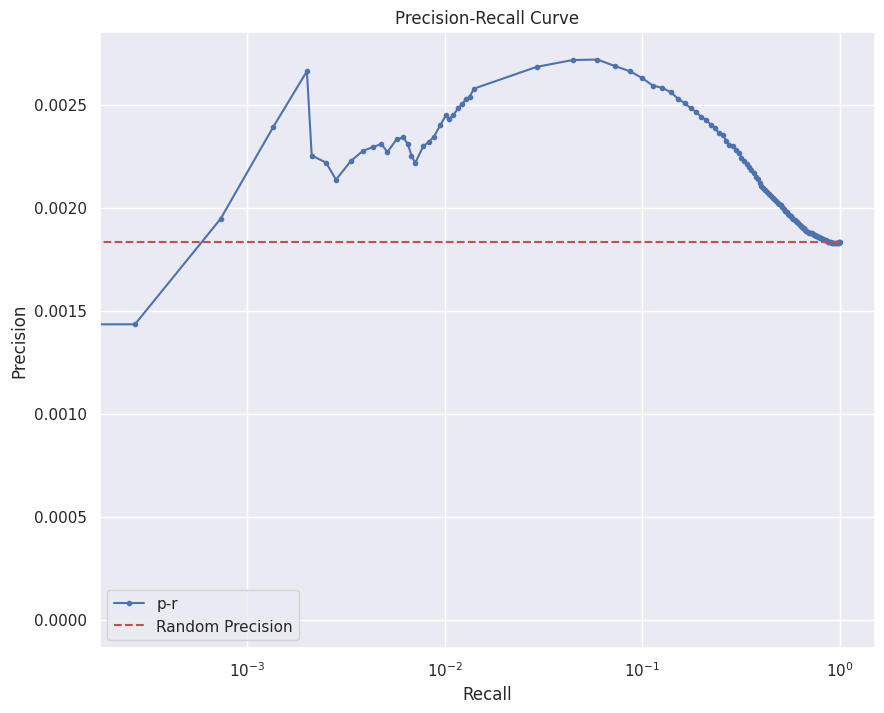

base enrichment
Top central genes: []


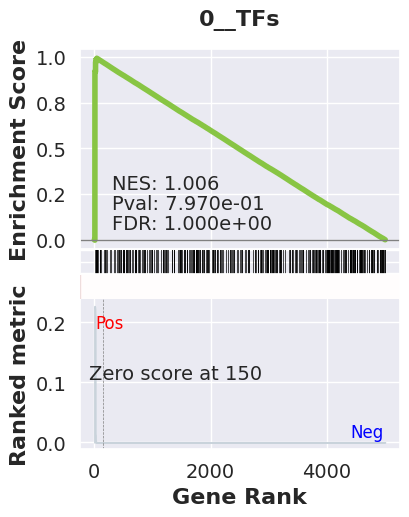

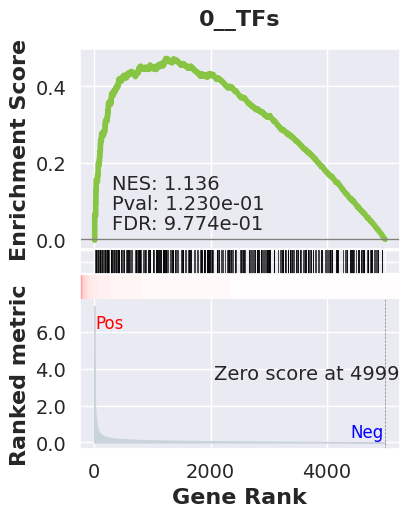

_________________________________________
TF specific enrichment
found some significant results for  7.575757575757576 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3763 genes
intersection pct: 0.7526
precision:  0.009170400982279404 
recall:  0.4502563311876036 
random precision: 0.0018325979065590518


 97%|█████████▋| 124/128 [00:02<00:00, 43.04it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 42.79it/s]


Average Precision (AP):  0.006025895318929323
Area Under Precision-Recall Curve (AUPRC):  0.005242267205200003
EPR: 7.051045767768945


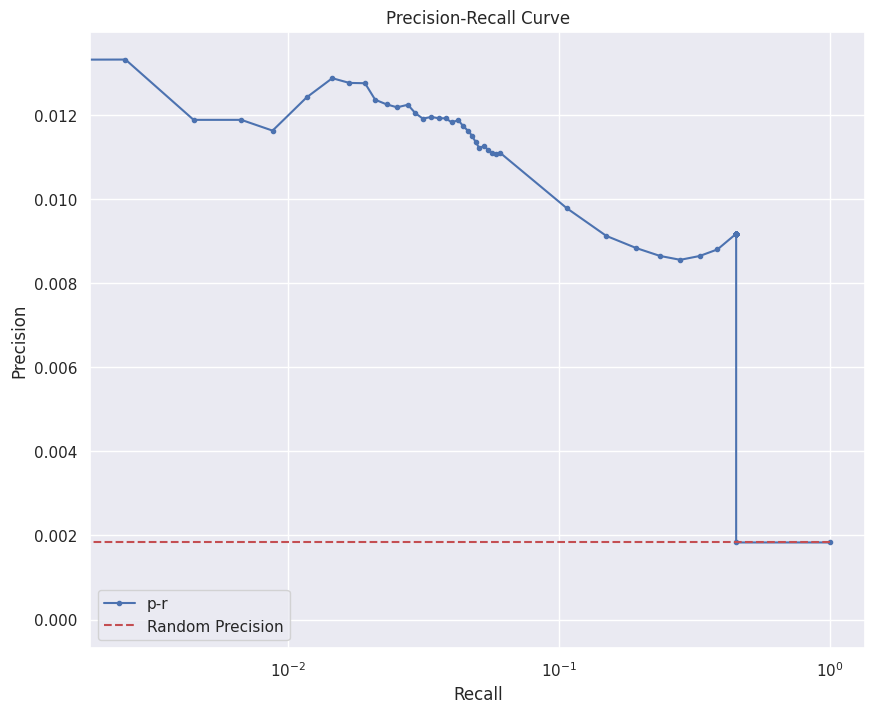

In [29]:
adata.var['ensembl_id'] = adata.var.index
adata = adata[adata.X.sum(1) > 500, adata.var.index.isin(gene_mapping_dict.keys())]
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
metrics = {}
shapes = []
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype][:MAXCELLS, adata.var.index.isin(to_use)]
    grn = compute_geneformer_network(
        subadata)
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    metrics['geneformer_'+celltype] = BenGRN(grn,
                                            do_auc=True, doplot=True).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF, :] = 0
    grn.var.index = make_index_unique(
        grn.var['symbol'].astype(str))
    metrics['geneformer_TF_'+celltype] = BenGRN(grn,
                                         do_auc=True, doplot=True).scprint_benchmark()
    shapes.append(grn.shape[1])

In [7]:
metrics

{'geneformer_retinal rod cell': {'TF_enr': False,
  'significant_enriched_TFtargets': 0.0,
  'precision': 0.0007555156889765451,
  'recall': 0.3545816733067729,
  'rand_precision': 0.0006670174487512689,
  'auprc': 0.0008124073085834153,
  'ap': 0.0009054023493249836,
  'epr': 0.0},
 'geneformer_TF_retinal rod cell': {'TF_enr': False,
  'significant_enriched_TFtargets': 66.66666666666667,
  'precision': 0.005376763032806047,
  'recall': 0.18326693227091634,
  'rand_precision': 0.0006670174487512689,
  'auprc': 0.0019526636510102642,
  'ap': 0.0024262226423799036,
  'epr': 12.122449637909066},
 'geneformer_Mueller cell': {'TF_enr': False,
  'enriched_terms_Regulators': ['celltype.gmt__Microglial cells'],
  'enriched_terms_Targets': ['celltype.gmt__Muller cells',
   'celltype.gmt__Adipocytes'],
  'significant_enriched_TFtargets': 17.24137931034483,
  'precision': 0.0013727051961657907,
  'recall': 0.9936172554198305,
  'rand_precision': 0.001376576029580251,
  'auprc': 0.0016706031836856

In [10]:
shapes

[2617, 4999, 4999, 5000, 4999, 4998, 4999, 4999, 4999, 4998]

In [ ]:
False
False
True
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
True
True

In [11]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

name        EPR     AUPRC      RAND    TF_targ  TF_enr  \
0         retinal rod cell   0.000000  0.000812  0.000667   0.000000   False   
1         retinal rod cell  12.122450  0.001953  0.000667  66.666667   False   
2             Mueller cell   1.802683  0.001671  0.001377  17.241379   False   
3             Mueller cell   6.450403  0.003670  0.001377   0.000000   False   
4            amacrine cell   1.378360  0.000943  0.000820  21.428571   False   
5            amacrine cell   4.153861  0.001447  0.000820   0.000000   False   
6          ON-bipolar cell   3.022855  0.000957  0.000768   6.666667   False   
7          ON-bipolar cell   3.174734  0.001136  0.000768   6.666667   False   
8         rod bipolar cell   1.607306  0.000874  0.000672   7.142857   False   
9         rod bipolar cell   4.842844  0.001002  0.000672  17.857143   False   
10       retinal cone cell   2.055039  0.000958  0.000768  15.151515   False   
11       retinal cone cell   8.018572  0.001585  0.000768  18.181818   False   
12  retina horizontal cell   0.906803  0.001208  0.001025  23.076923   False   
13  retina horizontal cell   4.798605  0.002039  0.001025  11.538462   False   
14   retinal ganglion cell   1.140990  0.001015  0.000953  12.500000   False   
15   retinal ganglion cell   4.428481  0.001528  0.000953   0.000000   False   
16               astrocyte   1.618360  0.001814  0.001432  24.000000   False   
17               astrocyte   6.678537  0.004041  0.001432   4.000000   False   
18         microglial cell   1.262838  0.002100  0.001833  30.303030   False   
19         microglial cell   6.828600  0.005204  0.001833   4.545455   False   

    TF_only  
0     False  
1     False  
2     False  
3     False  
4     False  
5     False  
6     False  
7     False  
8     False  
9     False  
10    False  
11    False  
12    False  
13    False  
14    False  
15    False  
16    False  
17    False  
18    False  
19    False